In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import get_scheduler
from tqdm import tqdm

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/DM Project/googleplaystore_user_reviews.csv')
data.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


In [ ]:
data.shape

(64295, 5)

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
lemmatizer = WordNetLemmatizer()

In [ ]:
def preprocess_text(text):
    # Tokenize text
    tokens = word_tokenize(text)
    # Lowercase all tokens
    tokens = [token.lower() for token in tokens]
    # Remove punctuation
    tokens = [token for token in tokens if token not in string.punctuation]
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    # Lemmatize tokens
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # Join tokens back into a single string
    return ' '.join(tokens)

In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
data = data.dropna(subset=['Translated_Review', 'Sentiment'])
data['Cleaned_Review'] = data['Translated_Review'].apply(preprocess_text)

In [ ]:
data['Sentiment'] = data['Sentiment'].map({'Positive': 2, 'Neutral': 1, 'Negative': 0})

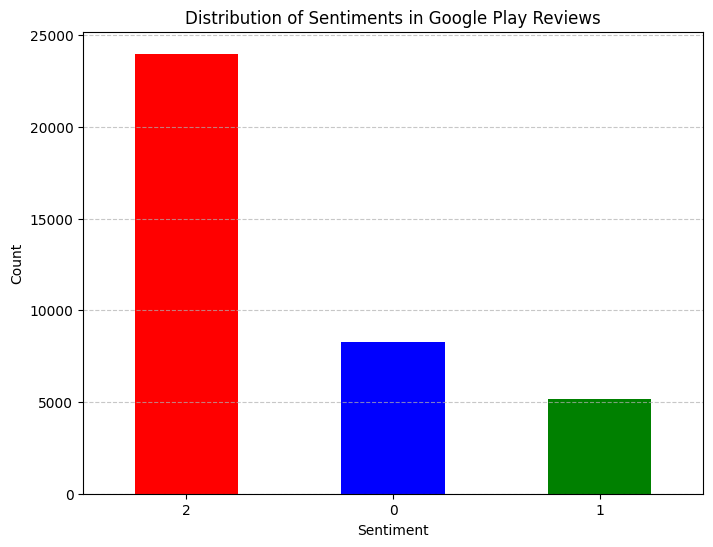

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data = data.dropna(subset=['Sentiment'])

# Count the sentiment values
sentiment_counts = data['Sentiment'].value_counts()

# Plot the bar chart
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['red', 'blue', 'green'])
plt.title('Distribution of Sentiments in Google Play Reviews')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    data['Cleaned_Review'].values,
    data['Sentiment'].values,
    test_size=0.2,
    random_state=42
)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
def tokenize_data(texts, tokenizer, max_len=128):
    return tokenizer(list(texts), padding=True, truncation=True, max_length=max_len, return_tensors="pt")


In [ ]:
train_encodings = tokenize_data(train_texts, tokenizer)
val_encodings = tokenize_data(val_texts, tokenizer)

In [ ]:
class ReviewDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {key: tensor[idx] for key, tensor in self.encodings.items()}, torch.tensor(self.labels[idx])

In [ ]:
train_dataset = ReviewDataset(train_encodings, train_labels)
val_dataset = ReviewDataset(val_encodings, val_labels)

In [ ]:
# Load data into DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

In [ ]:
from torch.optim import AdamW

In [ ]:
from torch.nn import CrossEntropyLoss

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Define class weights
class_counts = data['Sentiment'].value_counts()
total_samples = len(data)
class_weights = {label: total_samples / count for label, count in class_counts.items()}
weights_tensor = torch.tensor([class_weights[0], class_weights[1], class_weights[2]]).to(device)

# Define the weighted loss function
criterion = CrossEntropyLoss(weight=weights_tensor)

# Fine-Tuning BERT
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-5)
num_training_steps = len(train_loader) * 10
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


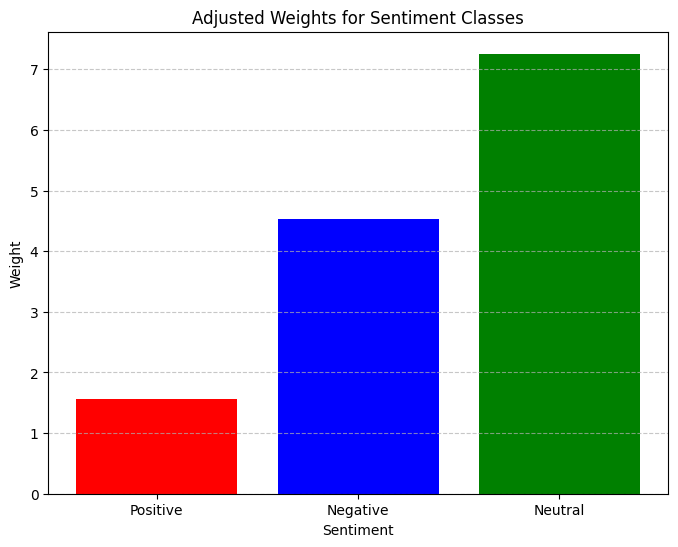

In [ ]:
adjusted_weights = [class_weights[2], class_weights[0], class_weights[1]]


sentiments = ['Positive', 'Negative', 'Neutral']


plt.figure(figsize=(8, 6))
plt.bar(sentiments, adjusted_weights, color=['red', 'blue', 'green'])
plt.title('Adjusted Weights for Sentiment Classes')
plt.xlabel('Sentiment')
plt.ylabel('Weight')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# Training Loop
model.train()
for epoch in range(10):
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        inputs, labels = batch
        inputs = {key: val.to(device) for key, val in inputs.items()}
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = criterion(outputs.logits, labels)  # Use weighted loss
        loss.backward()
        optimizer.step()

        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())


Epoch 9: 100%|██████████| 1872/1872 [10:35<00:00,  2.95it/s, loss=0.00225]


In [ ]:
# Evaluation
model.eval()
predictions, true_labels = [], []

with torch.no_grad():
    for batch in val_loader:
        inputs, labels = batch
        inputs = {key: val.to(device) for key, val in inputs.items()}
        labels = labels.to(device)

        outputs = model(**inputs)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)

        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

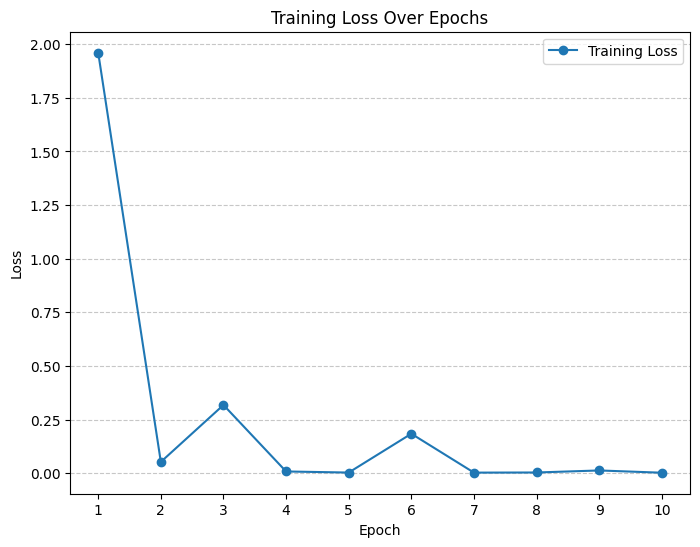

In [ ]:
import matplotlib.pyplot as plt

loss_values = [1.96, 0.0526, 0.318, 0.0081, 0.00303, 0.184, 0.00272, 0.00332, 0.0128, 0.00225]

# Plot the loss values
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(loss_values) + 1), loss_values, marker='o', label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(1, len(loss_values) + 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()


In [ ]:
# Classification Report
print(classification_report(true_labels, predictions, target_names=['Negative', 'Neutral', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.89      0.90      0.89      1653
     Neutral       0.92      0.92      0.92      1049
    Positive       0.96      0.96      0.96      4784

    accuracy                           0.94      7486
   macro avg       0.92      0.92      0.92      7486
weighted avg       0.94      0.94      0.94      7486



Classification Report:
              precision    recall  f1-score   support

    Negative       0.89      0.90      0.89      1653
     Neutral       0.92      0.92      0.92      1049
    Positive       0.96      0.96      0.96      4784

    accuracy                           0.94      7486
   macro avg       0.92      0.92      0.92      7486
weighted avg       0.94      0.94      0.94      7486



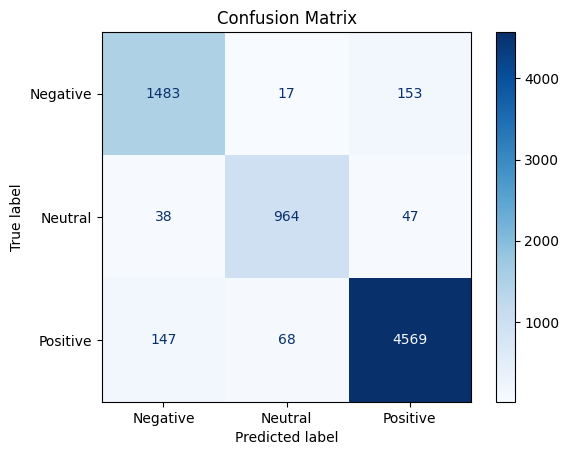

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(true_labels, predictions)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Negative', 'Neutral', 'Positive'])
disp.plot(cmap='Blues', values_format='d')

# Print classification report
print("Classification Report:")
print(classification_report(true_labels, predictions, target_names=['Negative', 'Neutral', 'Positive']))

# Show the confusion matrix plot
plt.title("Confusion Matrix")
plt.show()


In [ ]:
model.save_pretrained('/content/drive/MyDrive/DM Project/bert_sentiment_analysis_model')
tokenizer.save_pretrained('/content/drive/MyDrive/DM Project/bert_sentiment_analysis_model')

('/content/drive/MyDrive/DM Project/bert_sentiment_analysis_model/tokenizer_config.json',
 '/content/drive/MyDrive/DM Project/bert_sentiment_analysis_model/special_tokens_map.json',
 '/content/drive/MyDrive/DM Project/bert_sentiment_analysis_model/vocab.txt',
 '/content/drive/MyDrive/DM Project/bert_sentiment_analysis_model/added_tokens.json')

In [ ]:
# Inference on New Data
def predict_sentiment(texts, model, tokenizer):
    encodings = tokenize_data(texts, tokenizer)
    dataset = ReviewDataset(encodings, [0]*len(texts))  # Dummy labels
    loader = DataLoader(dataset, batch_size=16)

    predictions = []
    with torch.no_grad():
        for batch in loader:
            inputs, _ = batch
            inputs = {key: val.to(device) for key, val in inputs.items()}
            outputs = model(**inputs)
            preds = torch.argmax(outputs.logits, dim=-1)
            predictions.extend(preds.cpu().numpy())
    return predictions

new_reviews = ["Great app, very useful!","I like.", "Terrible experience, I lost all my saved data."]
predicted_sentiments = predict_sentiment(new_reviews, model, tokenizer)
print(predicted_sentiments)

[2, 1, 0]
